## Neural Network Assignment: Image Classification on MNIST
In this assignment, you will design and implement first a multi-layer perceptron model and then a convolutional network model in Pytorch. We will use the CIFAR-10 image dataset. Please complete the rest of the notebook by doing the following tasks.

- Build your network (A MLP model and a CONVNET model). There are some requirements on the network structure, please check the corresponding code sections. 
- Train your network. 
- Describe your training procedure. Plot the following:
    1. Training and validation loss vs. training iterations.
    2. Training and validation accuracy vs. training iterations.
- Report a final test result on 10000 separate testing examples.
- Give detailed explanation of your code

You can follow the skeleton code in the notebook to proceed. Look for the ##TODO## mark, that's where you should write your code. 

Check Pytorch documentation for reference: https://pytorch.org/tutorials/

## 1.1 Download data
From this website: https://www.cs.toronto.edu/~kriz/cifar.html
Download the CIFAR-10 python version, which is 163 MB. 
Extract the file you downloaded, you should be able to see a folder named cifar-10-batches-py. The data files are inside. ('data_batch_1', 'data_batch_2', etc..). To make things easier put these data files in a new folder called 'cifar-10-data'. The folder 'cifar-10-data' should be in the same directory as your jupyter notebook. Now we load the data into memory. 

# TODO you should download data

## 1.2 Loading Data: you should read the website's data description and have a better understanding of the data (quote):
Loaded in this way, each of the batch files contains a dictionary with the following elements:
data -- a 10000x3072 numpy array of uint8s. Each row of the array stores a 32x32 colour image. The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image.
labels -- a list of 10000 numbers in the range 0-9. The number at index i indicates the label of the ith image in the array data.

The dataset contains another file, called batches.meta. It too contains a Python dictionary object. It has the following entries:
label_names -- a 10-element list which gives meaningful names to the numeric labels in the labels array described above. For example, label_names[0] == "airplane", label_names[1] == "automobile", etc.


In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [2]:
## follow the instructions on the website
def unpickle(file):
    ## used to read binary files since our data files are in binary format
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [3]:
## loading data from binary data files
batch_1_dictionary = unpickle('cifar-10-data/data_batch_1')
batch_2_dictionary = unpickle('cifar-10-data/data_batch_2')

In [4]:
batch_1_dictionary.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

In [6]:
## get training, validation and testing sets
X_train_all = np.array(batch_1_dictionary[b'data']).reshape(10000,3,32,32)
y_train_all = np.array(batch_1_dictionary[b'labels'])
validation_count = 1000
train_count = X_train_all.shape[0]-1000
X_train = X_train_all[:train_count]
y_train = y_train_all[:train_count]
X_val = X_train_all[train_count:]
y_val = y_train_all[train_count:]
X_test = np.array(batch_2_dictionary[b'data']).reshape(10000,3,32,32)
y_test = np.array(batch_2_dictionary[b'labels'])

In [7]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((9000, 3, 32, 32),
 (9000,),
 (1000, 3, 32, 32),
 (1000,),
 (10000, 3, 32, 32),
 (10000,))

## 1.3 Preprocess Data
Typically public datasets have some kind of data description or manual that we can use to gain basic understanding of the dataset. You should always try to look for such things and utilize them before you start processing the data. We now want to preprocess the data. 

We now want to do a data normalization. (Do you still remember why data normalization is important? Refer to Normalizing Input in first week of Improving Deep Neural Networks: Hyperparameter tuning, Regularization and Optimization)
You can typically just do the minus by mean and divide by std normalization. But since we are dealing with image data, we can use another type of data normalization: simply divide by 255 to bring all features to the range (0,1).  (Think about why the number 255?) There are different ways to normalize data, feel free to try more options if you are interested. 

# TODO 
write your data normalization function here

In [7]:
# for RGB data we can simply divide by 255
X_train_normalized =  
X_val_normalized =  
X_test_normalized = 

## 1.4 Take a look at the data
We can plot the image data to have a better understanding of it.

In [8]:
## class label related
CLASSES = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def index_to_class_name(y):
    return CLASSES[y]
def class_name_to_index(class_name):
    return CLASSES.index(class_name)

In [9]:
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
"""
Plotting utilities, if you want to know how these work exactly, check the reference
Or the documentations
reference: 
https://matplotlib.org/users/image_tutorial.html
https://stackoverflow.com/questions/46615554/how-to-display-multiple-images-in-one-figure-correctly/46616645
""" 

def show_single_image(data):
    # show a single image
    ## note that using matplotlib plotting function, we will have to reshape the data as (1,32,32,3)
    img = data.reshape(3,32,32).transpose(1,2,0)
    imgplot = plt.imshow(img)
def show_multiple_images(data, data_y, n_show=12, columns=4):
    ## given an array of data, show all of them as images
    fig=plt.figure(figsize=(8, 8))
    n = min(data.shape[0], n_show)
    rows = math.ceil(n/columns)
    for i in range(n):
        img = data[i].reshape(3,32,32).transpose(1,2,0)
        ax = fig.add_subplot(rows, columns, i+1) ## subplot index starts from 1 not 0
        class_name = index_to_class_name(data_y[i])
        ax.set_title(str(data_y[i])+": "+class_name)
        plt.imshow(img)
    plt.show()

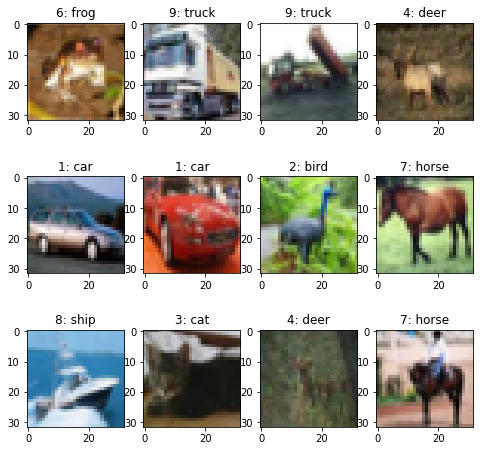

In [10]:
show_multiple_images(X_train, y_train)

## 2.1 Design Network Structure of a MLP Model
Reference: https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html

When we use a multi-layer perceptron (a very basic neural net with fully connected layers), we will need to flatten the data so that the MLP can use it. Each data point in our training data is currently in the form of 1x32x32x3, we want to convert it into 1x3072, so that its shape makes sense to our MLP's input layer. Recall that in our MLP, the input size for the first layer is 3072. There are multiple ways of doing this, we can directly flatten all data points, or we can also do the flattening for each mini-batch. 

In terms of the loss function, since we are doing the task of multi-class classification, we will use the cross entropy loss. 

We will use nn.CrossEntropyLoss to compute this, refer to Pytorch doc for details. A short summary is "this criterion combines nn.LogSoftmax() and nn.NLLLoss() in one single class" That basically means we don't have to worry about softmax layer and the log part. Make sure you read the Pytorch doc to understand exactly how it works. 

# TODO
write your network structure here

1. you should only use linear layers (nn.Linear), should use 2 or more linear layers
2. and you should use relu as activation
3. after the final layer we DON'T HAVE activation
4. you should not use softmax here because pytorch's BCE loss includes softmax
5. for hidden layer size, anything between 32-256 is OK

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
import torch.optim as optim

class MLP(nn.Module):
    ## a very simple MLP model
    def __init__(self, input_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = 
        self.fc2 = 
    def forward(self, x):

        return 

In [12]:
# utility for getting prediction accuracy
def get_correct_and_accuracy(y_pred, y):
    # y_pred is the nxC prediction scores
    # give the number of correct and the accuracy
    n = y.shape[0]
    # find the prediction class label
    _ ,pred_class = y_pred.max(dim=1)
    correct = (pred_class == y).sum().item()
    return correct ,correct/n

## 2.2 Training the MLP model
1. We first initialize the neural network, and also the optimizer and the criterion (loss function)
2. We then convert data into correct tensor form (note for MLP we need to flatten the image data, from 3x32x32 to 3072)
3. We then start doing training iterations

# TODO 
write code here 
1. init your model
2. use Adam optimizer, with lr=1e-3
3. use cross entropy criterion
4. for X_train, X_val, cast to Tensor and then reshape them to flatten them (change shape to mx3072)
5. for y_train, y_val, cast to Tensor and then cast to type long
6. simply do 100 iterations

In [15]:
# init network
mlp = MLP(3072, 10)
print('model structure: ',mlp)
# init optimizer
optimizer = 
# set loss function
criterion = 

# prepare for mini-batch stochastic gradient descent
n_iteration = 100
batch_size = 256
n_train_data = X_train_normalized.shape[0]
n_batch = int(np.ceil(n_train_data/batch_size))

# convert X_train and X_val to tensor and flatten them
X_train_tensor = 
X_val_tensor = 

# convert training label to tensor and to type long
y_train_tensor = 
y_val_tensor = 

model structure:  MLP(
  (fc1): Linear(in_features=3072, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=10, bias=True)
)


# TODO
1. Here you will have to write training code 
2. As well as code to log the training process for later plotting
3. After each iteration through training data, you should use that print function to log you current training process

In [16]:
## start 
train_loss_list = np.zeros(n_iteration)
train_accu_list = np.zeros(n_iteration)
val_loss_list = np.zeros(n_iteration)
val_accu_list = np.zeros(n_iteration)
for i in range(n_iteration):
    # first get a minibatch of data
    for j in range(n_batch):
        batch_start_index = j*batch_size
        # get data batch from the normalized data
        X_batch = X_train_tensor[batch_start_index:batch_start_index+batch_size]
        # get ground truth label y
        y_batch = y_train_tensor[batch_start_index:batch_start_index+batch_size]
        

    print("Iter %d ,Train loss: %.3f, Train acc: %.3f, Val loss: %.3f, Val acc: %.3f" 
          %(i ,ave_train_loss, train_accu, val_loss, val_accu)) 
    
    ## add to the logs so that we can use them later for plotting
    train_loss_list[i] = 
    train_accu_list[i] = 
    val_loss_list[i] = 
    val_accu_list[i] = 
    

Iter 0 ,Train loss: 2.195, Train acc: 0.188, Val loss: 2.064, Val acc: 0.253
Iter 1 ,Train loss: 2.009, Train acc: 0.279, Val loss: 1.959, Val acc: 0.297
Iter 2 ,Train loss: 1.922, Train acc: 0.316, Val loss: 1.915, Val acc: 0.305
Iter 3 ,Train loss: 1.873, Train acc: 0.336, Val loss: 1.885, Val acc: 0.329
Iter 4 ,Train loss: 1.837, Train acc: 0.353, Val loss: 1.864, Val acc: 0.335
Iter 5 ,Train loss: 1.812, Train acc: 0.359, Val loss: 1.850, Val acc: 0.350
Iter 6 ,Train loss: 1.788, Train acc: 0.369, Val loss: 1.835, Val acc: 0.354
Iter 7 ,Train loss: 1.766, Train acc: 0.375, Val loss: 1.822, Val acc: 0.361
Iter 8 ,Train loss: 1.750, Train acc: 0.381, Val loss: 1.813, Val acc: 0.359
Iter 9 ,Train loss: 1.734, Train acc: 0.386, Val loss: 1.804, Val acc: 0.366
Iter 10 ,Train loss: 1.721, Train acc: 0.392, Val loss: 1.795, Val acc: 0.367
Iter 11 ,Train loss: 1.708, Train acc: 0.397, Val loss: 1.788, Val acc: 0.373
Iter 12 ,Train loss: 1.697, Train acc: 0.399, Val loss: 1.786, Val acc: 0.

## 2.3 Plotting training process
We want to first plot training loss versus validation loss, then plot training accuracy, validation accuracy.

# TODO
run the plotting functions

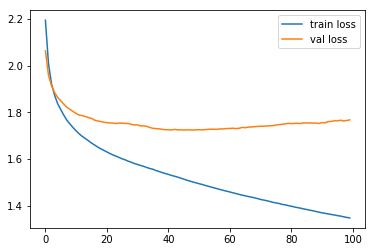

In [17]:
## plot training loss versus validation loss
x_axis = np.arange(n_iteration)
plt.plot(x_axis, train_loss_list, label='train loss')
plt.plot(x_axis, val_loss_list, label='val loss')
plt.legend()
plt.show()

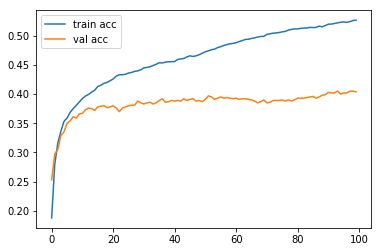

In [18]:
## plot training accuracy versus validation accuracy
plt.plot(x_axis, train_accu_list, label='train acc')
plt.plot(x_axis, val_accu_list, label='val acc')
plt.legend()
plt.show()

## 2.4 Report testing performance
We want run the trained model on test data to see how well it does

# TODO
write code here to report test accuracy on the 10000 test data

In [20]:
## test performance on the test set and report final performance

print("Test accuracy: " )

Test accuracy:  0.3903


## 3.1 Now we design a convolutional network
Check pytorch documentation for usage of each layer

# TODO
write network structure here
you should do:
1. use at least 2 conv layer
2. at least 1 maxpool layer
3. at least 2 linear layer at the end

In [21]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()


    def forward(self, x):

        return x

## 3.2 Training the Convolutional Net model
1. We first initialize the neural network, and also the optimizer and the criterion (loss function)
2. We then convert data into correct tensor form
3. We then start doing training iterations

# TODO 
write code here 
1. init your model
2. use Adam optimizer, with lr=1e-3
3. use cross entropy criterion
4. for X_train, X_val, cast to Tensor 
5. for y_train, y_val, cast to Tensor and then cast to type long
6. simply do 40 iterations

In [ ]:
# init network
conv_net = ConvNet()
print('model structure: ', conv_net)
# init optimizer
optimizer = 
# set loss function
criterion = 

# prepare for mini-batch stochastic gradient descent
n_iteration = 40
batch_size = 256
n_data = X_train_normalized.shape[0]
n_batch = int(np.ceil(n_data/batch_size))

# convert X_train and X_val to tensor and flatten them
X_train_tensor = 
X_val_tensor = 

# convert training label to tensor and to type long
y_train_tensor = 
y_val_tensor = 

print('X train tensor shape:', X_train_tensor.shape)

# TODO
1. Here you will have to write training code 
2. As well as code to log the training process for later plotting
3. After each iteration through training data, you should use that print function to log you current training process

In [23]:
## start 
train_loss_list = np.zeros(n_iteration)
train_accu_list = np.zeros(n_iteration)
val_loss_list = np.zeros(n_iteration)
val_accu_list = np.zeros(n_iteration)
for i in range(n_iteration):
    # first get a minibatch of data
    for j in range(n_batch):
        batch_start_index = j*batch_size
        # get data batch from the normalized data
        X_batch = X_train_tensor[batch_start_index:batch_start_index+batch_size]
        # get ground truth label y
        y_batch = y_train_tensor[batch_start_index:batch_start_index+batch_size]

    print("Iter %d ,Train loss: %.3f, Train acc: %.3f, Val loss: %.3f, Val acc: %.3f" 
          %(i ,ave_train_loss, train_accu, val_loss, val_accu)) 
    ## add to the logs so that we can use them later for plotting
    train_loss_list[i] = 
    train_accu_list[i] = 
    val_loss_list[i] = 
    val_accu_list[i] = 

Iter 0 ,Train loss: 2.185, Train acc: 0.182, Val loss: 2.058, Val acc: 0.223
Iter 1 ,Train loss: 2.004, Train acc: 0.258, Val loss: 1.962, Val acc: 0.273
Iter 2 ,Train loss: 1.904, Train acc: 0.298, Val loss: 1.840, Val acc: 0.308
Iter 3 ,Train loss: 1.798, Train acc: 0.338, Val loss: 1.766, Val acc: 0.342
Iter 4 ,Train loss: 1.707, Train acc: 0.376, Val loss: 1.724, Val acc: 0.358
Iter 5 ,Train loss: 1.628, Train acc: 0.410, Val loss: 1.684, Val acc: 0.383
Iter 6 ,Train loss: 1.562, Train acc: 0.436, Val loss: 1.625, Val acc: 0.401
Iter 7 ,Train loss: 1.515, Train acc: 0.450, Val loss: 1.591, Val acc: 0.419
Iter 8 ,Train loss: 1.469, Train acc: 0.471, Val loss: 1.567, Val acc: 0.427
Iter 9 ,Train loss: 1.427, Train acc: 0.482, Val loss: 1.565, Val acc: 0.436
Iter 10 ,Train loss: 1.399, Train acc: 0.493, Val loss: 1.563, Val acc: 0.436
Iter 11 ,Train loss: 1.377, Train acc: 0.504, Val loss: 1.539, Val acc: 0.445
Iter 12 ,Train loss: 1.343, Train acc: 0.515, Val loss: 1.513, Val acc: 0.

## 3.3 Plotting training process
We want to first plot training loss versus validation loss, then plot training accuracy, validation accuracy.

# TODO 
run the code here for plotting

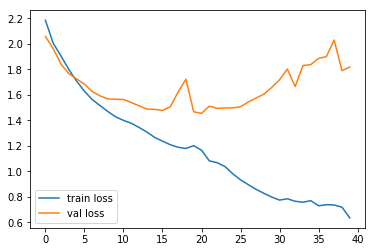

In [24]:
## plot training loss versus validation loss
x_axis = np.arange(n_iteration)
plt.plot(x_axis, train_loss_list, label='train loss')
plt.plot(x_axis, val_loss_list, label='val loss')
plt.legend()
plt.show()

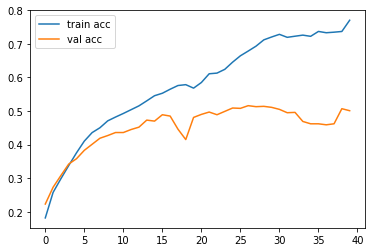

In [25]:
## plot training accuracy versus validation accuracy
plt.plot(x_axis, train_accu_list, label='train acc')
plt.plot(x_axis, val_accu_list, label='val acc')
plt.legend()
plt.show()

## 3.4 Report testing performance
We want run the trained model on test data to see how well it does

# TODO
write code here to report test accuracy on the 10000 test data

In [26]:
## test performance on the test set and report final performance
print("Test accuracy: ", )

Test accuracy:  0.5085


## Other things you can do to improve model performance: 
1. Add in regularization, you can use l2, Dropout
2. Use a better data normalization method
3. Train on more data
4. Do data augmentation to get more data
5. Use a more powerful network structure
6. Do transfer learning